# D213 - Advanced Data Analytics
### NLM3 Task 2: Sentiment Analysis Using Neural Networks
#### Advanced Data Analytics — D213
#### PRFA — NLM3
> André Davis
> StudentID: 010630641
> MSDA
>
> Competencies
> 4030.7.1 : Constructing Neural Networks
> The graduate builds neural networks in the context of machine-learning modeling.
> 
> 4030.7.3 : Natural Language Processing
> The graduate extracts insights from text data using effective and appropriate natural language processing (NLP) models.

##### Table of Contents

 <ul>
    <li><a href="#documentation">Documentation</a></li>
    <li><a href="#research-question">A1: Research Question</a></li>
    <li><a href="#objectives">A2: Objectives Or Goals</a></li>
    <li><a href="#neural-networks-identification">A3: Prescribed Network Neural Network Identification</a></li>
    <li><a href="#data-exploration">B1: Data Exploration</a></li>
    <li><a href="#tokenization-process">B2: Tokenization</a></li>
    <li><a href="#padding-process">B3: Padding Process</a></li> 
    <li><a href="#categories-of-sentiment">B4: Categories Of Sentiment</a></li>
    <li><a href="#data-preparation">B5: Steps To Prepare the Data</a></li>
    <li><a href="#copy-of-prepared-data">B6: Prepared Dataset</a></li>
    <li><a href="#tensorflow-model-summary">C1: Model Summary</a></li>
    <li><a href="#network-architecture">C2: Network Architecture</a></li>
    <li><a href="#hyperparameters">C3: Hyperparameters</a></li>
    <li><a href="#stopping-criteria">D1: Stopping Criteria</a></li>
    <li><a href="#fitness">D2: Fitness</a></li>
    <li><a href="#training-process">D3: Training Process</a></li>
    <li><a href="#predictive-accuracy">D4: Predictive Accuracy</a></li>
    <li><a href="#source-code">E: Code</a></li> 
    <li><a href="#functionality">H: Functionality</a></li> 
    <li><a href="#recommendations">G: Recommendeds</a></li>
    <li><a href="#reporting">H: Reporting</a></li>
    <li><a href="#code-references">I: Sources for Thirday Party Code</a></li>
    <li><a href="#source-references">J: Source References</a></li>    
  </ul>

# Documentation

 * [TensorFlow](https://www.tensorflow.org/)
 * [Keras](https://keras.io/)
     * [Dot Products](https://www.khanacademy.org/math/multivariable-calculus/thinking-about-multivariable-function/x786f2022:vectors-and-matrices/a/dot-products-mvc)    

## Python Package Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from typing import Tuple
from sklearn.metrics import mean_squared_error, confusion_matrix
from sklearn.model_selection import train_test_split
import seaborn as sns

#Unusual Character Checks
import emoji
from unidecode import unidecode

#Tensor-Flow Configuration
import tensorflow as tf
from keras.layers import Dense, Input, TextVectorization
from keras.losses import BinaryCrossentropy
from keras.models import Sequential
from keras.callbacks import History, EarlyStopping

assert tf.__version__ == '2.14.0', 'TensorFlow should be locked to 2.14.0 for this Performance Assessment'

print(f'TensorFlow Version: {tf.__version__}')
print('\n\n')

TensorFlow Version: 2.14.0




## Custom Python Functions

In [2]:
'''
Custom Utility functions for later activities
'''

def nameof(obj:any, g:dict=globals()) -> str:
    """
    :param obj: Any object that we want to return the string name of
    :type obj: any
     
    :param g: dictionary of globally accessible objects
    :type g: dict
    
    :return: a string representation of the objects name
    """
    return [name for name in g if g[name] is obj][0]

#test nameof function
assert nameof(mean_squared_error) ==  'mean_squared_error', 'nameof function should be returning the name of the object'

def nlp_data_split(data: pd.DataFrame
                   ,train_percentage:float=.8
                   ,validate_percentage:float=.1
                   ,test_percentage:float=.1) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """
    :param data: Data to be split for NLP processing
    :type data: pd.DataFrame 
    
    :param train_percentage: Percentage of data to use as model training data
    :type train_percentage: float
         
    :param validate_percentage: Percentage of data to use as model validation data
    :type validate_percentage: float
    
     
    :param test_percentage: Percentage of data to use as model testing data
    :type test_percentage: float
     
    :return: Tuple of pd.DataFrames broken into training, validation, and test data-frames.
    """

    assert (train_percentage + validate_percentage + test_percentage) == 1, 'Percentages must equal 1 (100%)'

    train, left_over = train_test_split(data, train_size=train_percentage, test_size=(validate_percentage + test_percentage))
    validate, test = train_test_split(left_over, train_size=.5, test_size=.5)

    return train, validate, test

def unusual_character_check(data: pd.DataFrame, column: str) -> bool:
    """
    :param data: Data to search for emojis and non-english characters
    :type data: pd.DataFrame
    
    :param column: Column of Data to check
    :type column: str    
     
    :return: list of unusual characters found
    """

    def check(text):
        if emoji.is_emoji(text) or unidecode(text) != text:
            return text
        else:
            return None

    results = pd.DataFrame()
    results['ContainsUnusual'] = data[column].apply(check)
    return results['ContainsUnusual'].isna().all()

def plot_accuracy_metrics(model_history:History, fig_size:tuple=(14,6)) -> None:
    """
    :param model_history: Sequence Model History (Accuracy Metrics)
    :type model_history: History
     
    :param fig_size: Figure Dimensions for Display
    :type fig_size: tuple
     
    :return: None
    """
    legend_labels = ['Training', 'Validation']
    title_template = 'Training Dataset vs. Validation Dataset ({})'
    
    _, (accuracy_axes, loss_axes) = plt.subplots(1, 2, figsize=fig_size)
    
    accuracy_axes.set_title(title_template.format('Accuracy'))
    accuracy_axes.set_xlabel('Epoch')
    accuracy_axes.set_ylabel('Accuracy')
    accuracy_axes.plot(model_history['loss'], label=legend_labels[0])
    accuracy_axes.plot(model_history['val_loss'], label=legend_labels[1])
    accuracy_axes.legend(legend_labels)
    
    loss_axes.set_title(title_template.format('Loss'))
    loss_axes.set_xlabel('Epoch')
    loss_axes.set_ylabel('Loss')
    loss_axes.plot(model_history['loss'], label=legend_labels[0])
    loss_axes.plot(model_history['val_loss'], label=legend_labels[1])
    loss_axes.legend(legend_labels)
    
    plt.tight_layout()
    plt.show()

<a id="research-question"></a>
# A1: Research Question

Is it feasible to ascertain the sentiment polarity—whether positive or negative—of a Review to a reasonably reliable extent, solely based on the textual content of the review?

<a id="objectives"></a>
# A2: Objectives and Goals of Analysis

The main goal of this analysis is to build a neural network model that can fairly accurately tell if a review is positive or negative based on its text.

<a id="neural-networks-identification"></a>
# A3: Prescribed Neural Network Identification

> Identify an industry-relevant type of neural network that can be trained to produce useful text classification predictions on text sequences on the selected data set.

There are quite a few text-classification neural networks that can be used. Because this is a [`WGU Performance Assessment`](https://tasks.wgu.edu/cb?code=3CVCSRrDonQaSnpxrGMGmrfBRQFhagMcj8YAAAAH&state=LNTIDpiCLNOniYarWEmqO8xbmNs1zaDdN-u1KNSbBS0) and most personal laptops don't have the computing power to perform some of the more complex neural networks without advanced GPU support [`Feedforward Neural Networks (FNN)`](https://en.wikipedia.org/wiki/Feedforward_neural_network). This is an advanced topic, and this particular neural network is known for its simplicity to implement and ability to function without higher end hardware.

It must be noted that because of its simplicity and low-resource needs, it does come with some limitations, which include:

1. Loss of neighborhood information (Suman, 2020)
2. More parameters to optimize (Suman, 2020)
3. It's not Translation invariance (Suman, 2020)

The limitations stemming from the lack of awareness regarding neighboring information preclude Feedforward Neural Networks (FNN) from effectively identifying patterns in data structures such as images, where understanding the relationship between neighboring pixels is crucial. However, in the context of text analysis for performance assessment, these limitations are not particularly detrimental.

<a id="data-exploration"></a>
# B1: Exploratory Data Analysis

> Perform exploratory data analysis on the chosen data set, and include an explanation of each of the following elements:
> * presence of unusual characters (e.g., emojis, non-English characters)
> * vocabulary size
> * proposed word embedding length
> * statistical justification for the chosen maximum sequence length

In [3]:
'''
File format as presented in the "readme.txt":

=======
Format:
=======
sentence \t score \n


=======
Details:
=======
Score is either 1 (for positive) or 0 (for negative)
'''
review_columns = ['review', 'sentiment_score']
read_engine = 'python'
seperator = '\t+'

imdb_reviews = pd.read_csv('./imdb_labelled.txt', engine=read_engine, sep=seperator, header=None, names=review_columns)
amazon_reviews = pd.read_csv('./amazon_cells_labelled.txt', engine=read_engine, sep=seperator, header=None, names=review_columns)
yelp_reviews = pd.read_csv('./yelp_labelled.txt', engine=read_engine, sep=seperator, header=None, names=review_columns)


In [4]:
print(imdb_reviews.info())
print('\n')
print(amazon_reviews.info())
print('\n')
print(yelp_reviews.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   review           1000 non-null   object
 1   sentiment_score  1000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 15.8+ KB
None


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   review           1000 non-null   object
 1   sentiment_score  1000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 15.8+ KB
None


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   review           1000 non-null   object
 1   sentiment_score  1000 non-null   int64 
dtypes: int64(1), object(1)
m

In [5]:
'''
Merge Datasets into one
'''

merged_reviews = pd.concat([imdb_reviews, amazon_reviews, yelp_reviews], ignore_index=True)

In [6]:
print(merged_reviews.value_counts())

review                                                                                              sentiment_score
This is a great deal.                                                                               1                  2
Works great.                                                                                        1                  2
Not recommended.                                                                                    0                  2
I won't be back.                                                                                    0                  2
I love this place.                                                                                  1                  2
                                                                                                                      ..
I rather enjoyed it.                                                                                1                  1
I really do recommend this place, you

In [7]:
'''
readme.txt states that the data should contain 500 positive and 500 negative sentences, a 50/50 split.

NOTE: All 3 UC-Irvine datasets have been loaded and merged into one dataset.

Verifying dataset is complete
'''

total_positive_sentiments = len(merged_reviews[merged_reviews[review_columns[1]] == 1])
total_negative_sentiments = len(merged_reviews[merged_reviews[review_columns[1]] == 0])

print(f'Positive Sentiments Loaded: {total_positive_sentiments}')
print(f'Negative Sentiments Loaded: {total_negative_sentiments}')

assert total_positive_sentiments == 1500, 'Failed to load all the positive sentiment scores'
assert total_negative_sentiments == 1500, 'Failed to load all the negative sentiment scores'


Positive Sentiments Loaded: 1500
Negative Sentiments Loaded: 1500


In [8]:
'''
Check for missing values
'''
missing_data_check = merged_reviews.isna().sum()

assert missing_data_check.review == 0, 'Reviews should not contain an missing review data'
assert missing_data_check.sentiment_score == 0, 'Sentiment Scores should not contain any missing sentiment score data'

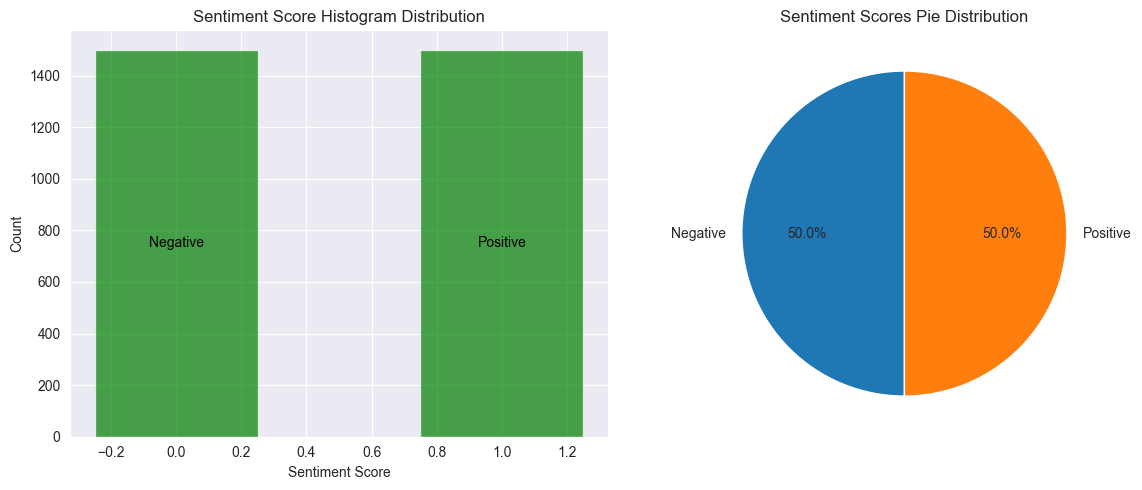

In [9]:
'''
Chart Distribution of Sentiment Score to visually check 50/50 dataset assumption.
'''

sentiment_counts = [total_negative_sentiments, total_positive_sentiments]

_, (hist_axes, pie_axis) = plt.subplots(1, 2, figsize=(12, 5))

hist_axes.hist(merged_reviews[review_columns[1]], bins=[-.5, .5, 1.5], rwidth=.5, color='green', alpha=.7)
hist_axes.set_xlabel('Sentiment Score')
hist_axes.set_ylabel('Count')
hist_axes.set_title('Sentiment Score Histogram Distribution')

for index, sentiment_count in enumerate(sentiment_counts):
    position = (sentiment_count / 2)
    label = 'Negative' if index == 0 else 'Positive'
    
    hist_axes.text(index, position, label, color='black', ha='center', va='center')

pie_axis.pie(sentiment_counts, labels=['Negative', 'Positive'], autopct='%1.1f%%', startangle=90)
pie_axis.set_title('Sentiment Scores Pie Distribution')

plt.tight_layout()
plt.show()

### Presence of unusual characters (e.g., emojis, non-English characters)

In [10]:
'''
Check for Unusual Characters
'''

contains_unusual = unusual_character_check(merged_reviews, review_columns[0])
print(f'Does dataset contains unusual characters such as Emojis or Non-English characters: [{contains_unusual}]')

assert contains_unusual == False, 'Dataset should not contain any unusual characters.'

Does dataset contains unusual characters such as Emojis or Non-English characters: [False]


### Vocabulary Size

Please see section B2 where the Tokenization process will expose the Vocabulary Size.

Results will be printed to screen in format: *'The Reviews dataset contains a vocabulary size of [n] based on the 80% training dataset.'*

### Proposed Word Embedding Length

The recommended embedding size is set at *100*. Typically, the dimensionality of an embedding is influenced by available computational resources and the nature of the data. Given that we are conducting a performance review on a concise dataset comprising 1,000 entries, extensive computational power isn't necessary. Furthermore, the specificity of the data to reviews justifies this choice.

### Statistical justification for the chosen maximum sequence length

The sequence length was set at 5000, established through an examination of the dataset to identify the length of the longest review. While some platforms permit review lengths approaching 10,000 to 20,000 characters, such extensive lengths are observed to be exceptions rather than the norm. This assertion is supported by the fact that the shortest review length encountered in our analysis was 7 characters. It's important to note that shorter reviews do not inherently equate to superior reviews.

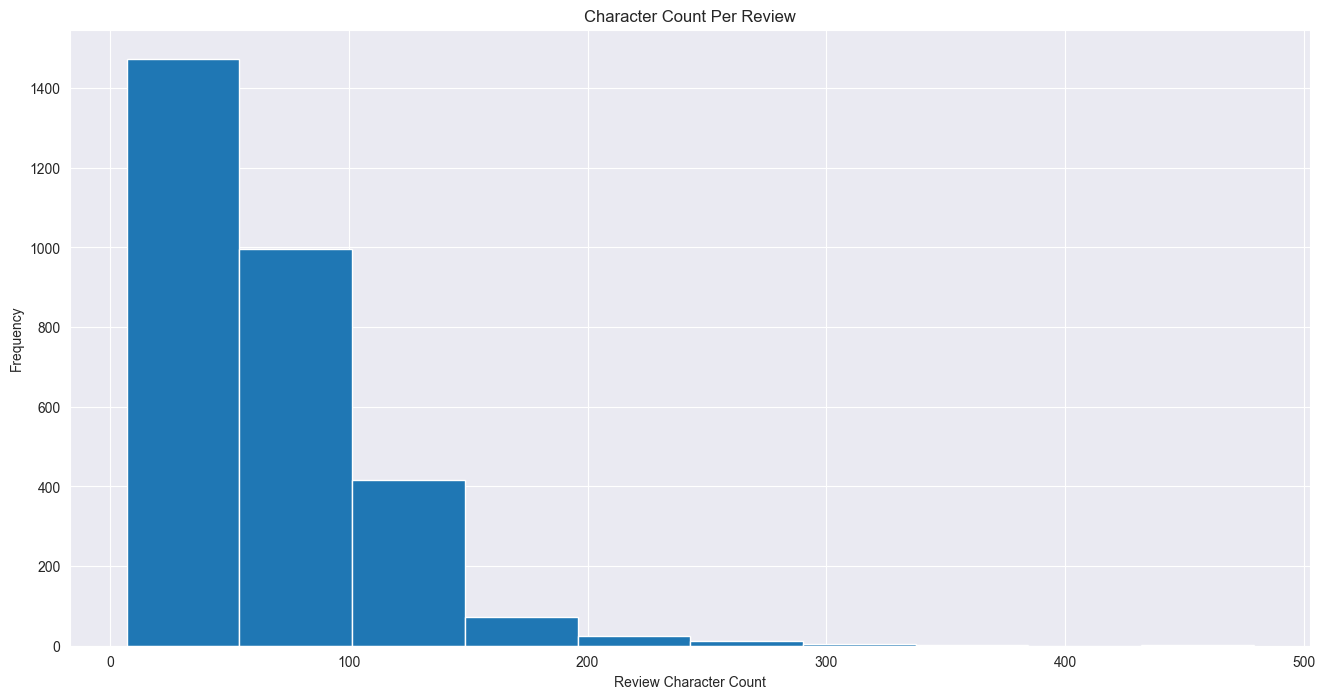

In [11]:
review_character_lengths = pd.DataFrame()
review_character_lengths['CharacterLength'] = merged_reviews[review_columns[0]].str.len()

plt.figure(figsize=(16,8))
plt.hist(review_character_lengths['CharacterLength'])

plt.title('Character Count Per Review')
plt.xlabel('Review Character Count')
plt.ylabel('Frequency')
plt.grid(True)

plt.show()

##### Minimum & Maximum Review lengths per platform:
 * Amazon - Max: 20000 | Books Max: 4000
 * IMDB - Min: 600 | Max: 10000
 * Yelp - Max: 5000 
##### Summary Statistics for Character Length Per Review:

The current Maximum of provided datasets is 479 characters, with the minimum being 7.

In [12]:
percentiles = [.25, .5, .75, 1]
summary_statistics_data = review_character_lengths['CharacterLength'].describe(percentiles=percentiles)
print(summary_statistics_data)

count    3000.000000
mean       65.271333
std        44.163566
min         7.000000
25%        33.000000
50%        55.500000
75%        88.000000
100%      479.000000
max       479.000000
Name: CharacterLength, dtype: float64


<a id="tokenization-process"></a>
# B2: Tokenization

"Tokenization is the process of breaking down a piece of text into small units called tokens. A token may be a word, part of a word or just characters like punctuation." (Perry, n.d.). For a simple example, we could end up with a text containing *"Rick and Morty go on adventures."* Then during the tokenization process ('chunking') we would potentially end up with a collection of tokens such as:

1. Rick
2. and
3. Morty
4. go
5. on
6. adventures
7. .

Take notice that the period (.) became a token as well. In the vectorization process, sometimes a text is standardized where punctuation and casing are removed.

There are many different libraries and ways to perform tokenization such as [`Natural Language Toolkit - NLTK`](https://www.nltk.org/). For the purposes of this performance assessment the [`Keras`](https://keras.io/) [`TextVectorization`](https://keras.io/api/layers/preprocessing_layers/core_preprocessing_layers/text_vectorization/) will be used.

In [13]:
'''
Split the Reviews into 80% training data 10% validation data, and 10% test data.
'''
train_reviews, validation_reviews, testing_reviews = nlp_data_split(merged_reviews)

embedding_padding_length = 5000

training_reviews_feature = train_reviews[review_columns[0]]

text_vectorizer = TextVectorization(max_tokens=5000, output_sequence_length=embedding_padding_length, standardize='lower_and_strip_punctuation')
text_vectorizer.adapt(training_reviews_feature)

trained_vocabulary_size = text_vectorizer.vocabulary_size()
trained_vocabularies = text_vectorizer.get_vocabulary()

unique_vocabulary = set(trained_vocabularies)
assert len(unique_vocabulary) == len(trained_vocabularies), 'Should be no duplicates'

trained_tokens_df = pd.DataFrame({
    'Tokens': trained_vocabularies
})

b1_vocabulary_size = f'''
The Reviews dataset contains a vocabulary size of [{trained_vocabulary_size}] based on the 80% training dataset.
'''
print(b1_vocabulary_size)



The Reviews dataset contains a vocabulary size of [4773] based on the 80% training dataset.


<a id="padding-process"></a>
# B3: Padding Process

In the machine learning realm, there are many models that require consistent length inputs. Padding is pre-processing step where adding extra values (usually zeros) to data to make them all the same size. This is done because many machine learning models require consistent input sizes. For example, in processing text, if we have sentences of different lengths but our model expects all sentences to have the same number of words, we add extra "empty" words to shorter sentences until they match the length of the longest one. This ensures the model can handle all the data uniformly.

This Performance Assessment is using the [`Keras TextVectorization`](https://keras.io/api/layers/preprocessing_layers/core_preprocessing_layers/text_vectorization/) function. It includes a parameter `output_sequence_length`, which will add padding when items are too short and truncate when items are too long. Below is verification of padding based on the previous example text of *"Rick and Morty go on adventures."*

In [14]:
verification_review = 'This was a flick doomed from its conception.'
verification_review_vectors = text_vectorizer([verification_review])

validation_reviews_tokens = list()
for i in verification_review_vectors[0]:
    validation_reviews_tokens.append(trained_vocabularies[i])

verification_message = f'''
Mock Text: {verification_review}
Tokens: {validation_reviews_tokens}
Embeddings: {verification_review_vectors}
'''
print(verification_message)

assert len(verification_review) < len(verification_review_vectors[0]), f'Failed padding process to make all vectors (embeddings) an equal size of {embedding_padding_length}'
assert len(verification_review_vectors[0]) == embedding_padding_length, f'The text [{verification_review}] should have had its vector padded to {embedding_padding_length}'


Mock Text: This was a flick doomed from its conception.
Tokens: ['this', 'was', 'a', 'flick', 'doomed', 'from', 'its', 'conception', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ''

<a id="categories-of-sentiment"></a>
# B4: Categories Of Sentiment

The **Categories of Sentiment** for the [`Combined IMDB, Amazon, and Yelp Datasets`](https://archive.ics.uci.edu/dataset/331/sentiment+labelled+sentences) is Binary Sentiment Classification as there are only two possible classifications. The classification categories are 1—Positive or 0—Negative. Demonstrated in the below code.

In [15]:
sentiment_scores = merged_reviews[review_columns[1]]

total_categories_of_sentiment = sentiment_scores.nunique()
available_categories_of_sentiment = list(sentiment_scores.value_counts().index)

assert total_categories_of_sentiment == 2, 'The total categories of sentiment should have been 2 as the IMDB reviews are either positive or negative'
assert available_categories_of_sentiment == [0, 1], 'Category values should only include 0 or 1, representing Negative or Positive'

sentiment_score_label = {
    0: 'Negative',
    1: 'Positive'
}
 
categories_of_sentiment_summary = f'''
Total Categories of Sentiment: {total_categories_of_sentiment}
Available Categories of Sentiment: {available_categories_of_sentiment}

Legend: 
 0 - {sentiment_score_label.get(0)}
 1 - {sentiment_score_label.get(1)}   
'''

print(categories_of_sentiment_summary)



Total Categories of Sentiment: 2
Available Categories of Sentiment: [0, 1]

Legend: 
 0 - Negative
 1 - Positive   


<a id="data-preparation"></a>
# B5: Steps To Prepare the Data
>Explain the steps used to prepare the data for analysis, including the size of the training, validation, and test set split (based on the industry average).

The dataset that is being used is in a `.txt` format. Which in the `readme.txt` supplied from the [`UC Irvine Machine Learning Repository`](https://archive.ics.uci.edu/dataset/331/sentiment+labelled+sentences) indicates that the file is formatted as *sentence \t score \n*.

Data Preparation Steps:
1. Load the each `.txt` file (`amazon_cells_labelled.txt`, `imdb_labelled.txt`, `yelp_labelled.txt`) with Pandas function [`.read_csv`](https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html) with settings based on the `readme.txt` file format. Data is separated by a tab, and each data entry is on a new-line.
2. Merge data sets (imdb, amazon, and yelp) using [`Pandas Concact`](https://pandas.pydata.org/docs/reference/api/pandas.concat.html) function.
3. Use custom function `nlp_data_split` to split the data into training, validation, and testing datasets.
    * Industry standard for NLP splits is:
        * Training -> 80%
        * Validation -> 10%
        * Testing -> 10%
4. Tokenize Training Data

NLP Split Verification Code:

In [16]:
'''
Verify Raw Text Reviews have been properly split for NLP.
'''

#original data
total_data_count = len(merged_reviews)

#split data
training_data_count = len(train_reviews)
validation_data_count = len(validation_reviews)
testing_data_count = len(testing_reviews)

training_percentage = training_data_count/total_data_count 
assert training_percentage == .8, f'Training data should be 80% of original data, received [{training_percentage}]'

validation_percentage = validation_data_count/total_data_count
assert validation_percentage == .1, f'Validation data should be 10% of original data, received [{validation_percentage}]'

testing_percentage = testing_data_count/total_data_count
assert testing_percentage == .1, f'Testing data should be 10% of original data, received [{testing_percentage}]'

<a id="copy-of-prepared-data"></a>
# B6: Prepared Dataset

In [17]:
'''
Save to CSV IMDB Reviews Data Sets for NLP split into Training, Validation, and Test
'''
train_reviews.to_csv('./merged-reviews-training-dataset.csv')
validation_reviews.to_csv('./merged-reviews-validation-dataset.csv')
testing_reviews.to_csv('./merged-reviews-testing-dataset.csv')

'''
Tokenized IMDB Reviews based on Training Dataset
'''
trained_tokens_df.to_csv('./merged-reviews-training-dataset-tokenized.csv', index=False)

<a id="tensorflow-model-summary"></a>
# C1: Model Summary
>The submission provides the complete output of the model summary of the function from TensorFlow. The output aligns with the type of network used.

In [18]:
#Initialize Sequential Model
sequential_model = Sequential([
    #Add Embedding (Vectorization) Layer with check for Input 1Dness
    Input(shape=(1,), dtype=tf.string),
    text_vectorizer,
    
    #There is no definitive formula that can specify the exact architecture for a neural network that will work best for a given dataset. Experimenting
    Dense(6, activation='relu'),
    Dense(1, activation='softmax')
])

'''
Loss Function: BinaryCrossentropy
Description: Computes the cross-entropy loss between true labels and predicted labels.
Documentation: https://www.tensorflow.org/api_docs/python/tf/keras/losses/BinaryCrossentropy
'''

loss_function = BinaryCrossentropy()

sequential_model.compile(optimizer='adam', loss=loss_function, metrics=['accuracy'])
sequential_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 5000)              0         
 ctorization)                                                    
                                                                 
 dense (Dense)               (None, 6)                 30006     
                                                                 
 dense_1 (Dense)             (None, 1)                 7         
                                                                 
Total params: 30013 (117.24 KB)
Trainable params: 30013 (117.24 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


<a id="network-architecture"></a>
# C2: Network Architecture
>The submission completely and accurately discusses the number of layers, the type of layers, and the total number of parameters in the network.

The Network Architecture of the [`Sequential Model`](https://keras.io/guides/sequential_model/) has 4 layers:

 * The First Layer is the Input layer. This layer is set as `Input(shape=(1,), dtype=tf.string)` which indicates that each input item is a 1-dimensional array of text.
 * Second Layer is the [`TextVectorization`](https://keras.io/api/layers/preprocessing_layers/core_preprocessing_layers/text_vectorization/) which handles converting text into tokens and then vectorization (embeddings).
 * Third Layer is a [`Dense`](https://keras.io/api/layers/core_layers/dense/) layer which is the hidden layer. In this case, it's initialized with 6 neurons and uses the activation function 'relu'. The Total number of parameters is *606*
 * Fourth Layer is which the `softmax` activation function is applied and includes 7 parameters.

The summary of the above Sequential Model is:

Total params: 613 (2.39 KB)
Trainable params: 613 (2.39 KB)
Non-trainable params: 0 (0.00 Byte)

<a id="hyperparameters"></a>
# C3: Hyperparameters
>The submission logically justifies the choice of hyperparameters, including each of the 6 listed elements, and each element aligns with the network used.

Hyperparameters used for this Sequential Model include:

 * **Activation Function**: [`ReLU`](https://keras.io/api/layers/activation_layers/relu/) is the activation function used for our Network. This type of activation function returns the value it gets if it's positive otherwise if it's negative it will return 0. This is considered a low latency activation function for neural networks and has pretty good performance and helps make training easier. <br /><br />
 * **Nodes Per Layer**: Even with merging the three datasets 1500 rows in a dataset is pretty small. The hidden layer (3rd Layer) uses 6 nodes, and the output layer (4th Layer) has one node for the output. <br /><br />
 * **Loss Function**: Our sentiment scores are binary, and we want probabilistic loss so we used the loss function 'BinaryCrossentropy()' <br /><br />
 * **Optimizer**: Throughout the demonstrations in this course it was recommended to use the `adam` optimizer as it is great for working with smaller limited datasets. It does this because it has dynamic learning rates. <br /><br />
 * **Stopping Criteria**: [`EarlyStopping`](https://keras.io/api/callbacks/early_stopping/) was used to help prevent over-fitting of the model. It also stops the training process if things begin to degrade performance wise. <br /><br />
 * **Evaluation Metric**: [`Accuracy`](https://keras.io/api/metrics/accuracy_metrics/) was chosen for our metrics. It is used to calculate how often the labels and predictions are equal.    <br /><br />

<a id="stopping-criteria"></a>
# D1: Stopping Criteria
>The submission accurately discusses the impact of using stopping criteria to include defining the number of epochs. A screenshot showing the final training epoch is provided.

In [19]:
'''
Train the Sequential Model
'''

x_train_reviews = train_reviews[review_columns[0]]
y_train_sentiment_scores = train_reviews[review_columns[1]]

x_validation_reviews = validation_reviews[review_columns[0]]
y_validation_sentiment_scores = validation_reviews[review_columns[1]]

validation_data = (x_validation_reviews, y_validation_sentiment_scores)

#Actually train the model.
model_results = sequential_model.fit(x=x_train_reviews
                                    ,y=y_train_sentiment_scores
                                    ,validation_data=validation_data
                                    ,callbacks=EarlyStopping(monitor='val_loss')
                                    ,epochs=50)

Epoch 1/50
75/75 [==============================] - 1s 4ms/step - loss: 7.9258 - accuracy: 0.5067 - val_loss: 2.0787 - val_accuracy: 0.4967
Epoch 2/50
75/75 [==============================] - 0s 2ms/step - loss: 1.6613 - accuracy: 0.5067 - val_loss: 1.1141 - val_accuracy: 0.4967
Epoch 3/50
75/75 [==============================] - 0s 2ms/step - loss: 0.8207 - accuracy: 0.5067 - val_loss: 0.9265 - val_accuracy: 0.4967
Epoch 4/50
75/75 [==============================] - 0s 2ms/step - loss: 0.7164 - accuracy: 0.5067 - val_loss: 0.8435 - val_accuracy: 0.4967
Epoch 5/50
75/75 [==============================] - 0s 2ms/step - loss: 0.6926 - accuracy: 0.5067 - val_loss: 0.8079 - val_accuracy: 0.4967
Epoch 6/50
75/75 [==============================] - 0s 2ms/step - loss: 0.6926 - accuracy: 0.5067 - val_loss: 0.8345 - val_accuracy: 0.4967


Early stopping is a form of regularization used to avoid over-fitting when training a learner with an iterative method, such as gradient descent. This technique stops training as soon as the validation error reaches a minimum. The [`Sequenctial Model`](https://keras.io/guides/sequential_model/) used here was assigned 50 epochs and an [`EarlyStopping`](https://keras.io/api/callbacks/early_stopping/) which monitors validation loss (`val_loss`). This means the training will stop when the validation loss stops improving, which essentially means it has found a minimum. We can see in the screenshot below of the previous results that the early stopping caused the fit-process to stop at 4 out of 50 epochs. This ensures that the model trains only until it's beneficial.

![Early Stopping Screenshot](final-training-epoch.png)

<a id="fitness"></a>
# D2: Fitness
>The submission completely and accurately assesses the fitness of the model, and the assessment includes any actions taken to address overfitting.

In [20]:
'''
Evaluate the Model
'''
x_test_reviews = testing_reviews[review_columns[0]]
y_test_sentiment_scores = testing_reviews[review_columns[1]]

(loss, accuracy) = sequential_model.evaluate(x_test_reviews, y_test_sentiment_scores)

evaluation = f'''
Model Evaluation with Test Dataset Results:
===========================================
Loss Function Used: {nameof(BinaryCrossentropy)} [Loss closer to 0 is best.]

Loss: {loss}
Accuracy: {accuracy}
'''
print(evaluation)

10/10 [==============================] - 0s 2ms/step - loss: 0.8593 - accuracy: 0.4500

Model Evaluation with Test Dataset Results:
Loss Function Used: BinaryCrossentropy [Loss closer to 0 is best.]

Loss: 0.859283983707428
Accuracy: 0.44999998807907104


The evaluation of the model didn't turn out too well. 

###### Assessment:
 * The loss is a little high as it should be targeted as close to 0 as we can get. This suggests that the model is not fitting the data.
 * The accuracy percentage is barley above 50%. This indicates that the resulting model is not better than random guessing.

###### Actions:
 * Double-check the data quality. Checking for noisy or inconsistent data
 * Tune-Hyperparameters: Attempt to run experiment again adjusting *Activation Function*, *Nodes Per Layer*, *Loss Function*, *Optimizer*, *Stopping Criteria*, and *Evaluation Metric*.
 * Potentially attempt a different Model altogether, if tuning-hyperparameters isn't producing better results. 

<a id="training-process"></a>
# D3: Training Process
>The submission provides complete visualizations of the model’s training process, including a line graph of the loss and the chosen evaluation metric. The visualizations are clearly labeled and align with the model’s training process.

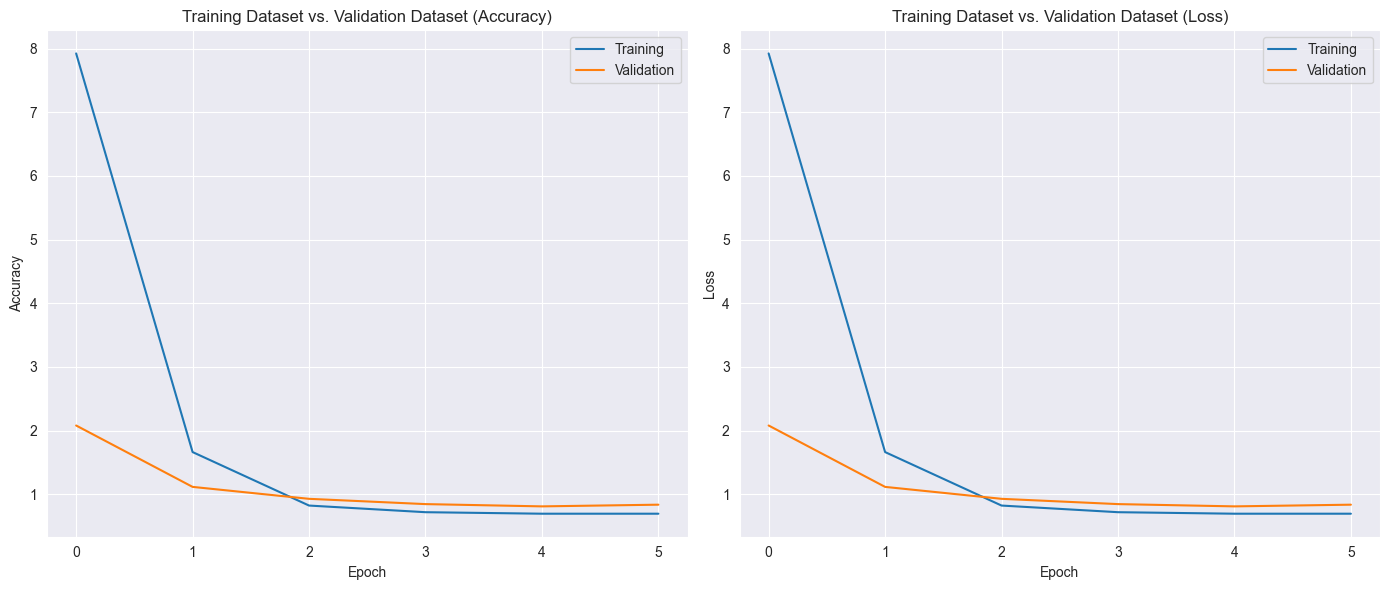

In [21]:
'''
Chart Accuracy and Lost Metrics
'''

plot_accuracy_metrics(model_results.history)

<a id="predictive-accuracy"></a>
# D4: Predictive Accuracy
>The submission discusses the predictive accuracy of the trained network using the chosen evaluation metric from part D3.

In [22]:
'''
Generate predictions of sentiment scores
'''
y_sentiment_score_predictions = sequential_model.predict(x_test_reviews)

10/10 [==============================] - 0s 2ms/step


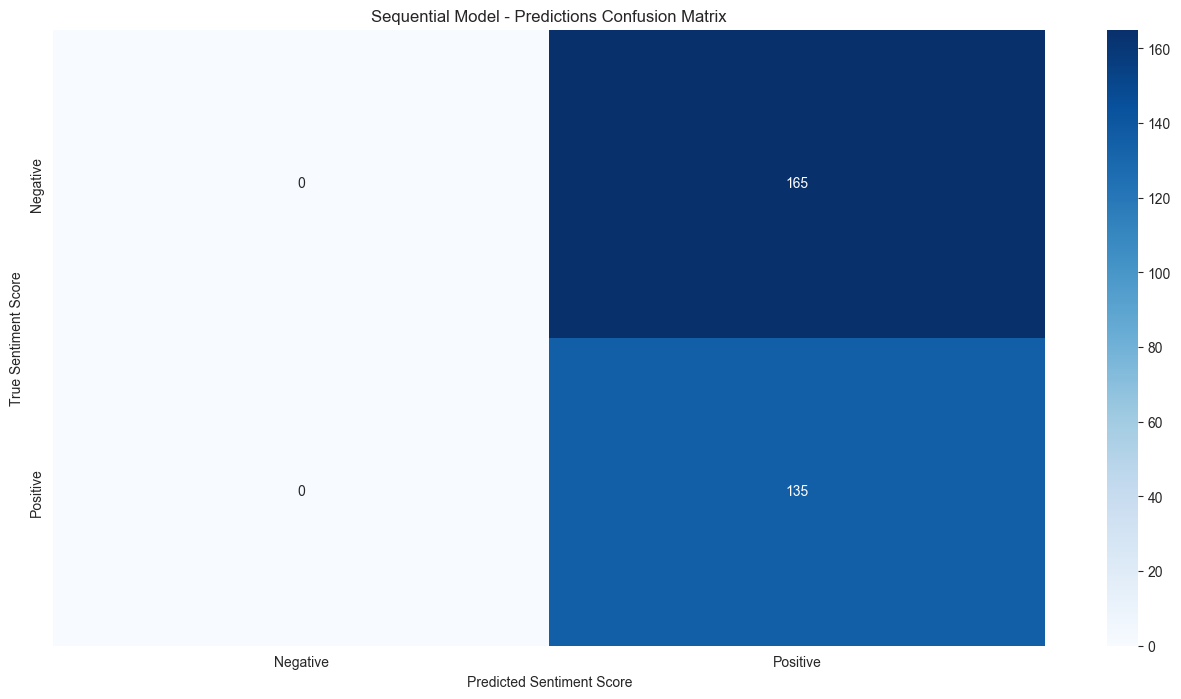

In [23]:
'''
Generate a Confusion Matrix to create a truth table
'''
c_matrix = confusion_matrix(y_test_sentiment_scores, y_sentiment_score_predictions)

heatmap_labels = ['Negative', 'Positive']

plt.figure(figsize=(16,8))
sns.heatmap(c_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=heatmap_labels, yticklabels=heatmap_labels)
plt.xlabel('Predicted Sentiment Score')
plt.ylabel('True Sentiment Score')
plt.title('Sequential Model - Predictions Confusion Matrix')

plt.show()

###### Interpretation:
 - True Negatives (TN): 0
 - False Positives (FP): 153
 - False Negatives (FN): 0
 - True Positives (TP): 147

The model demonstrates a significant bias towards predicting the 'Positive' class while consistently failing to identify instances of the 'Negative' class. This behavior points to an underlying imbalance in the model's predictive capabilities and aligns with the previously observed suboptimal performance metrics.

# Save the model

In [24]:
'''
Save the Model
'''
sequential_model.save('./sentiment_classification_model', save_format='tf') #.h5 This file format is considered legacy.

INFO:tensorflow:Assets written to: ./sentiment_classification_model\assets


INFO:tensorflow:Assets written to: ./sentiment_classification_model\assets


<a id="source-code"></a>
# E: Code

##### NOTE: This Jupyter Notebook (`.ipynb`) is acting as the Paper and Code together. Please review the notebook for all sections of appropriate code.

<a id="functionality"></a>
# H: Functionality
>The submission accurately discusses the functionality of the neural network, including the impact of the network architecture. The discussion aligns with the research question from part A.

The model employs a Feedforward Neural Network (FNN) architecture, which is designed for straightforward, one-way data flow from the input to the output layers. This type of network is effective for tasks like classifying the sentiment in a given text, such as reviews. By learning from both the training and test datasets, the model aims to gain a comprehensive understanding of the reviews it analyzes. Unlike RNNs, the FNN doesn't have a loop-back feature, but it is optimized to identify keywords or phrases that are critical for sentiment analysis, improving its predictive capabilities.

However, it's important to note that despite these theoretical advantages, the model did not perform well in practice, as evidenced by the confusion matrix previously presented. The model exhibited a significant bias towards predicting the 'Positive' class and failed to correctly identify the 'Negative' class, indicating an underlying issue that needs to be addressed for improved performance.

<a id="recommendations"></a>
# G: Recommendations
>The submission recommends an appropriate course of action based on the results as they relate to the research question.

Because the confusion matrix confirmed the poor performance that was demonstrated in Section D2 Fitness report the recommendations hold and will be reiterated here as: 

###### Actions:
 * Double-check the data quality. Checking for noisy or inconsistent data
 * Tune-Hyperparameters: Attempt to run experiment again adjusting *Activation Function*, *Nodes Per Layer*, *Loss Function*, *Optimizer*, *Stopping Criteria*, and *Evaluation Metric*.
 * Potentially attempt a different Model altogether, if tuning-hyperparameters isn't producing better results. 

<a id="reporting"></a>
# H: Reporting
>The neural network is shown in an industry-relevant interactive development environment and is complete, accurate, and in alignment with the data analysis of the report. A PDF or HTML document of the executed notebook presentation is provided.

This D213 Performance Assessment Task 2 was completed as an all-in-one code and paper through Jupyter Notebook. A fully executed PDF version of a successful run will be submitted along with the .ipynb file.

<a id="code-references"></a>
# I: Sources for Third Party Code

##### N/A

<a id="source-references"></a>
# J: Source References

 * Kotzias,Dimitrios. (2015). Sentiment Labelled Sentences. UCI Machine Learning Repository. https://doi.org/10.24432/C57604. <br /> <br />
 * Géron, A. (2022). Hands-On Machine Learning with Scikit-Learn, Keras, and Tensorflow: Concepts, Tools, and Techniques to Build Intelligent Systems. <br /><br /> 
 * Suman, A. (2020, Sept). Limitation of NN and CNN. Medium. https://anjanisuman.medium.com/limitation-of-nn-and-cnn-ee21a4cdc9eb <br /> <br />
 * Tal Perry. (n.d.). What is Tokenization in Natural Language Processing? Retrieved from https://www.machinelearningplus.com/nlp/what-is-tokenization-in-natural-language-processing/<br /> <br />
 * Brownlee, J. (August 25, 2020). How to Stop Training Deep Neural Networks at the Right Time Using Early Stopping. Machine Learning Mastery. https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/ <br /> <br />
 